In [8]:
list_config_1 = ["+", "+", "-", "-"]
list_config_2 = ["+", "+", "+", "+"]
list_config_3 = ["-", "-", "-", "-"]
list_config_4 = ["+", "+", "+", "-"]
list_config_5 = ["+", "-", "-", "-"]

In [9]:
#write permutations of 0,1,2,3
def permute(list_config):
    if len(list_config) == 0:
        return []
    if len(list_config) == 1:
        return [list_config]
    l = []
    for i in range(len(list_config)):
        m = list_config[i]
        remLst = list_config[:i] + list_config[i+1:]
        for p in permute(remLst):
            l.append([m] + p)
    return l

In [10]:
index = permute([0,1,2,3])

In [11]:
set_ = [] 

for set_of_index in index:
    string = ''
    for i in set_of_index:
        string += list_config_1[i] 
    set_.append(string)

In [12]:
strings = set(set_)
strings

{'++--', '+-+-', '+--+', '-++-', '-+-+', '--++'}

In [13]:
def find_interacting_pairs(index, string):
    neibours = {'0':[1, 2, 1, 2], '1':[0, 3, 0, 3], '2':[0, 3, 0, 3], '3':[1, 2, 1, 2]}
    neibours = neibours[str(index)]
    interacting_pairs = [(string[index], string[x]) for x in neibours]
    return interacting_pairs

In [14]:
test = find_interacting_pairs(0, '+-++')
test

[('+', '-'), ('+', '+'), ('+', '-'), ('+', '+')]

In [15]:
def find_energy_given_string_of_configurations(string):
    """
    notice we are taking into account the periodic boundary conditions
    """
    energy = 0
    for i in range(len(string)):
        interacting_pairs = find_interacting_pairs(i, string)
        for a,b in interacting_pairs:
            a += '1'
            b += '1'
            prod = a + '*' +b
            energy += eval(prod)
    return (-1/2)*energy ## notice the minus sign and that we count each pair twice

In [16]:
find_energy_given_string_of_configurations('+---')

-0.0

In [17]:
strings

{'++--', '+-+-', '+--+', '-++-', '-+-+', '--++'}

In [19]:
ising_model(strings)

{'++--': -0.0,
 '+-+-': -0.0,
 '-++-': 8.0,
 '-+-+': -0.0,
 '--++': -0.0,
 '+--+': 8.0}

In [20]:
#### scaling the problem

In [12]:
## Generate random configurations of N = L X L spins
import random 
import numpy as np
def init_random_config(L):
    """
    L is the length of the square lattice
    """
    configurations = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            configurations[i, j] = random.choice([+1, -1])
    return configurations

In [13]:
configuration = init_random_config(10)
configuration 


array([[ 1., -1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.],
       [-1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.],
       [ 1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1.],
       [-1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.],
       [-1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.],
       [ 1., -1., -1., -1., -1.,  1., -1., -1., -1., -1.],
       [ 1., -1., -1., -1.,  1., -1.,  1.,  1., -1., -1.],
       [-1.,  1., -1., -1.,  1., -1., -1., -1., -1.,  1.],
       [-1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.],
       [ 1., -1.,  1., -1., -1.,  1., -1., -1., -1.,  1.]])

In [14]:
index = 4
L = 5
top_neibours = [(index - L)%25, (index + L)%25]
top_neibours

[24, 9]

In [81]:
def find_interacting_pairs(index, raveled_config, L):
    side_neibours = [(index - 1) % L + L*(index//L), (index + 1) % L+ L*(index//L)]
    top_neibours = [(index - L)%(L*L), (index + L)%(L*L)]
    neibours = side_neibours + top_neibours
    #print('index', index,'neibours', neibours)
    #print('len raveled config', len(raveled_config))
    interacting_pairs = [(raveled_config[index], raveled_config[x]) for x in neibours]
    return interacting_pairs

In [99]:
# evolve the system given the initial configuration and boltzmann probability
def evolve(config, beta):
    L = len(config)
    raveled_config = config.ravel()
    for i in range(L*L):
        interacting_pairs = find_interacting_pairs(i, raveled_config, L)
        energy = 0
        for a,b in interacting_pairs:
            energy += -(a*b)

        delta_E = -2*energy # because delta_E = E_new - E_old = -((-a)*b) - (-(a*b)) = 2*(a*b) = -2*energy
        if delta_E < 0: # if the energy is lower, accept the new configuration
            raveled_config[i] *= -1
        else:
            if random.random() < np.exp(-beta*delta_E): # if the energy is higher, accept the new configuration with a probability
                raveled_config[i] *= -1
    return raveled_config.reshape(L,L)

In [100]:
## seems to work
test = find_interacting_pairs(0, configuration.ravel(), 5)
test

[(1.0, 1.0), (1.0, 1.0), (1.0, 1.0), (1.0, 1.0)]

In [101]:
def find_energy_given_array_of_configurations(configuration, L):
    """
    notice we are taking into account the periodic boundary conditions
    """
    energy = 0
    raveled_config = configuration.ravel()
    ## this is dumb now but will be useful later when we select only one term to flip

    for i in range(len(raveled_config)):
        ## i will be the index of the term. k,l will be the coordinates of the term

        interacting_pairs = find_interacting_pairs(i, raveled_config, L)
        for a, b in interacting_pairs:
            energy += a*b
    return (-1/2)*energy ## notice the minus sign and that we count each pair twice

In [131]:
# plot a 2d grid of the L x L spins
from time import sleep 
import matplotlib.pyplot as plt
def plot_configurations(L, init=False, epochs=None):
    """
    configurations is a 2d array of the L x L spins
    """
    if init: # else we are evolving the system
        configuration = init_random_config(L)
        energy = find_energy_given_array_of_configurations(configuration, L)
        plt.imshow(configuration, cmap = 'Purples', interpolation = 'nearest')
        plt.title(f'Energy = {energy}')

        plt.show()
    else:
        configuration = init_random_config(L)

        kb = 1 ## only for testing
        T = 1
        beta = 1/(kb*T)
        for i in range(epochs):
            configuration = evolve(configuration, beta)
            energy = find_energy_given_array_of_configurations(configuration, L)
            plt.imshow(configuration, cmap = 'Purples', interpolation = 'nearest')
            plt.title(f'Energy = {energy}')
            # animate the plot wit
            plt.clf()
            plt.plot()
            sleep(0.1)

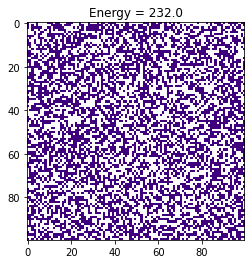

In [132]:
plot_configurations(100, init=True)

KeyboardInterrupt: 

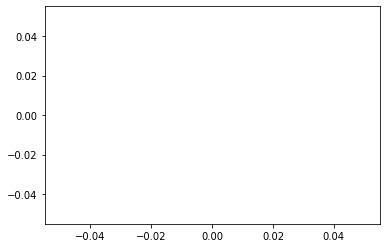

In [133]:
plot_configurations(100, init=False, epochs=100)

In [142]:
9//7

1

In [141]:
8%7

1